In [22]:
# =====================================================
# One-shot experiment runner: compare several TF-IDF baselines
# Outputs:
#   /mnt/data/ml_comparison/results.csv
#   /mnt/data/ml_comparison/frozen_splits.json  (if not already in ml_clean)
#   /mnt/data/ml_comparison/best/*  (best model artifacts)
# =====================================================

import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path
from typing import Optional, Tuple
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, recall_score, classification_report

# ----------------------------
# Config
# ----------------------------
DATA_PATH = "/content/final_data_preprocessed.csv"
TEXT_COL  = "text_clean"
TARGET    = "17_impact_type"

RANDOM_STATE = 42
# 70 / 20 / 10 split
TEST_SIZE = 0.10   # 10% test
VAL_SIZE  = 0.20   # 20% validation

# how much of the remaining 90% becomes validation
val_frac_from_train = VAL_SIZE / (1 - TEST_SIZE)


BASE_OUT = Path("/mnt/data/ml_comparison")
BASE_OUT.mkdir(parents=True, exist_ok=True)
SPLITS_CLEAN = Path("/mnt/data/ml_clean/frozen_splits.json")  # reuse if exists
SPLITS_COMP  = BASE_OUT / "frozen_splits.json"                # else save here

# ----------------------------
# Load data
# ----------------------------
df = pd.read_csv(DATA_PATH).dropna(subset=[TEXT_COL, TARGET]).reset_index(drop=True)
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()

le = LabelEncoder()
y = le.fit_transform(df[TARGET].astype(str))
labels = le.classes_.tolist()

# ----------------------------
# Frozen splits (reuse if already created)
# ----------------------------
def make_or_load_splits() -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if SPLITS_CLEAN.exists():
        splits = json.load(open(SPLITS_CLEAN))
    elif SPLITS_COMP.exists():
        splits = json.load(open(SPLITS_COMP))
    else:
        # Create new frozen splits
        X_text = df[TEXT_COL].values
        X_train_text, X_test_text, y_train_, y_test_, idx_train_all, idx_test = train_test_split(
            X_text, y, np.arange(len(df)), test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
        )
        val_frac_from_train = VAL_SIZE / (1 - TEST_SIZE)
        X_train_text, X_val_text, y_train_, y_val_, idx_train, idx_val = train_test_split(
            X_train_text, y_train_, idx_train_all, test_size=val_frac_from_train,
            stratify=y_train_, random_state=RANDOM_STATE
        )
        splits = {
            "random_state": RANDOM_STATE, "test_size": TEST_SIZE, "val_size": VAL_SIZE,
            "train_indices": idx_train.tolist(), "val_indices": idx_val.tolist(), "test_indices": idx_test.tolist()
        }
        json.dump(splits, open(SPLITS_COMP, "w"), indent=2)
    return np.array(splits["train_indices"]), np.array(splits["val_indices"]), np.array(splits["test_indices"])

idx_train, idx_val, idx_test = make_or_load_splits()

X_train_text = df.loc[idx_train, TEXT_COL].values
X_val_text   = df.loc[idx_val,   TEXT_COL].values
X_test_text  = df.loc[idx_test,  TEXT_COL].values
y_train, y_val, y_test = y[idx_train], y[idx_val], y[idx_test]

# ----------------------------
# Helpers
# ----------------------------
def calibrate_prefit(base_est, X_val, y_val):
    """Calibrate a pre-fitted classifier once on the validation set."""
    cal = CalibratedClassifierCV(base_est, method="sigmoid", cv="prefit")
    cal.fit(X_val, y_val)
    return cal

def evaluate(name: str, vec: TfidfVectorizer, Xtr, ytr, Xva, yva, Xte, yte, base_estimator, save_dir: Path):
    """Fit base estimator, calibrate on val, evaluate on test, save artifacts."""
    # fit on train
    base = base_estimator.fit(Xtr, ytr)
    # calibrate once using validation
    model = calibrate_prefit(base, Xva, yva)
    # test predictions
    y_pred = model.predict(Xte)
    macro_f1 = f1_score(yte, y_pred, average="macro")
    macro_rec = recall_score(yte, y_pred, average="macro")
    # probs for saving
    try:
        p_ml = model.predict_proba(Xte)
    except Exception:
        # fallback from decision_function
        scores = model.decision_function(Xte)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
        e = np.exp(scores - scores.max(axis=1, keepdims=True))
        p_ml = e / e.sum(axis=1, keepdims=True)

    # save artifacts for this run
    save_dir.mkdir(parents=True, exist_ok=True)
    joblib.dump(vec, save_dir / "tfidf_vectorizer.pkl")
    joblib.dump(model, save_dir / "best_model.pkl")
    joblib.dump(le,   save_dir / "label_encoder.pkl")
    pd.DataFrame({
        "index": idx_test,
        "y_true": le.inverse_transform(yte),
        "y_pred_ml": le.inverse_transform(y_pred)
    }).sort_values("index").to_csv(save_dir / "y_pred_ml.csv", index=False)
    pd.DataFrame(p_ml, columns=[f"p_{c}" for c in labels]).to_csv(save_dir / "p_ml.csv", index=False)

    # --- FIX: Dynamically determine labels present in yte ---
    # Get unique labels actually present in yte
    unique_yte_labels = np.unique(yte)
    # Map these to original label names
    target_names_for_report = [labels[i] for i in unique_yte_labels]

    open(save_dir / "classification_report.txt", "w").write(
        classification_report(yte, y_pred, target_names=target_names_for_report, labels=unique_yte_labels, digits=3)
    )
    return {"name": name, "macro_F1": float(macro_f1), "macro_recall": float(macro_rec), "dir": str(save_dir)}

def vec_word12(custom_stopwords: Optional[set] = None):
    # merge custom list with english stopwords if provided
    if custom_stopwords:
        stopwords = list(custom_stopwords) + ["english"]
    else:
        stopwords = "english"
    return TfidfVectorizer(
        ngram_range=(1,2), min_df=2, max_df=0.95,
        stop_words=stopwords, strip_accents="unicode",
        sublinear_tf=True, smooth_idf=True
    )

def vec_char35():
    return TfidfVectorizer(
        analyzer="char", ngram_range=(3,5), min_df=2, sublinear_tf=True
    )

def svc(C=1.0):
    return LinearSVC(C=C, class_weight="balanced", random_state=RANDOM_STATE)

def logreg(C=1.0):
    base = LogisticRegression(C=C, max_iter=1500, solver="saga", n_jobs=-1, class_weight="balanced")
    return OneVsRestClassifier(base, n_jobs=-1)

# ----------------------------
# Build custom stopword list = top 30 frequent terms (by mean TF-IDF on train)
# ----------------------------
def top_terms_stoplist(Xtr, vec, top_n=30):
    feat = np.array(vec.get_feature_names_out())
    mean_tfidf = Xtr.mean(axis=0).A1
    top_idx = np.argsort(mean_tfidf)[-top_n:][::-1]
    return set(feat[top_idx])

# ----------------------------
# Run experiments
# ----------------------------
results = []

# 1) Word 1-2 grams + LinearSVC (C=0.5 and 1.0)
for C in [0.5, 1.0]:
    v = vec_word12()
    Xtr = v.fit_transform(X_train_text)
    Xva = v.transform(X_val_text)
    Xte = v.transform(X_test_text)
    res = evaluate(
        name=f"word12_LinSVC_C{C}",
        vec=v, Xtr=Xtr, ytr=y_train, Xva=Xva, yva=y_val, Xte=Xte, yte=y_test,
        base_estimator=svc(C),
        save_dir=BASE_OUT / f"word12_LinSVC_C{C}"
    )
    results.append(res)

# 2) Char 3-5 grams + LinearSVC (C=1.0)
v = vec_char35()
Xtr = v.fit_transform(X_train_text); Xva = v.transform(X_val_text); Xte = v.transform(X_test_text)
results.append(
    evaluate("char35_LinSVC_C1.0", v, Xtr, y_train, Xva, y_val, Xte, y_test, svc(1.0), BASE_OUT / "char35_LinSVC_C1.0")
)

# 3) Word 1-2 grams + SVD(300) + LinearSVC (C=1.0)
v = vec_word12()
Xtr = v.fit_transform(X_train_text); Xva = v.transform(X_val_text); Xte = v.transform(X_test_text)
svd = TruncatedSVD(n_components=300, random_state=RANDOM_STATE)
Xtr_s = svd.fit_transform(Xtr); Xva_s = svd.transform(Xva); Xte_s = svd.transform(Xte)
# wrap estimator as usual
base = svc(1.0).fit(Xtr_s, y_train)
cal  = calibrate_prefit(base, Xva_s, y_val)
y_pred = cal.predict(Xte_s)
macro_f1 = f1_score(y_test, y_pred, average="macro")
macro_rec = recall_score(y_test, y_pred, average="macro")
# save artifacts for this run
run_dir = BASE_OUT / "word12_SVD300_LinSVC_C1.0"
run_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(v,   run_dir / "tfidf_vectorizer.pkl")
joblib.dump(svd, run_dir / "svd.pkl")
joblib.dump(cal, run_dir / "best_model.pkl")
joblib.dump(le,  run_dir / "label_encoder.pkl")
pd.DataFrame({
    "index": idx_test, "y_true": le.inverse_transform(y_test), "y_pred_ml": le.inverse_transform(y_pred)
}).sort_values("index").to_csv(run_dir / "y_pred_ml.csv", index=False)

# --- FIX: Dynamically determine labels present in y_test for SVD part ---
unique_y_test_labels = np.unique(y_test)
target_names_for_report_svd = [labels[i] for i in unique_y_test_labels]

open(run_dir / "classification_report.txt", "w").write(
    classification_report(y_test, y_pred, target_names=target_names_for_report_svd, labels=unique_y_test_labels, digits=3)
)
results.append({"name": "word12_SVD300_LinSVC_C1.0", "macro_F1": float(macro_f1), "macro_recall": float(macro_rec), "dir": str(run_dir)})

# 4) Word 1-2 grams + Logistic Regression (OVR, C=1.0)
v = vec_word12()
Xtr = v.fit_transform(X_train_text); Xva = v.transform(X_val_text); Xte = v.transform(X_test_text)
results.append(
    evaluate("word12_LogRegOVR_C1.0", v, Xtr, y_train, Xva, y_val, Xte, y_test, logreg(1.0), BASE_OUT / "word12_LogRegOVR_C1.0")
)

# 5) Word 1-2 grams (exclude top-30 frequent terms) + LinearSVC (C=1.0)
v_tmp = vec_word12()
Xtr_tmp = v_tmp.fit_transform(X_train_text)
stop30 = top_terms_stoplist(Xtr_tmp, v_tmp, top_n=30)
v = vec_word12(custom_stopwords=stop30)
Xtr = v.fit_transform(X_train_text); Xva = v.transform(X_val_text); Xte = v.transform(X_test_text)
results.append(
    evaluate("word12_exclTop30_LinSVC_C1.0", v, Xtr, y_train, Xva, y_val, Xte, y_test, svc(1.0), BASE_OUT / "word12_exclTop30_LinSVC_C1.0")
)

# ----------------------------
# Save comparison table + best artifacts
# ----------------------------
res_df = pd.DataFrame(results).sort_values("macro_F1", ascending=False)
res_df.to_csv(BASE_OUT / "results.csv", index=False)

best_row = res_df.iloc[0]
best_dir = Path(best_row["dir"])
BEST_EXPORT = BASE_OUT / "best"
BEST_EXPORT.mkdir(exist_ok=True)

# copy artifacts to unified /best/
for fname in ["tfidf_vectorizer.pkl", "best_model.pkl", "label_encoder.pkl", "svd.pkl", "y_pred_ml.csv", "classification_report.txt"]:
    src = best_dir / fname
    if src.exists():
        import shutil
        shutil.copy2(src, BEST_EXPORT / fname)

# Also save a short metrics JSON for the best
json.dump({
    "best_run": best_row["name"],
    "macro_F1": round(float(best_row["macro_F1"]), 4),
    "macro_recall": round(float(best_row["macro_recall"]), 4),
    "artifacts_dir": str(BEST_EXPORT)
}, open(BEST_EXPORT / "metrics.json", "w"), indent=2)

print("Wrote:", str(BASE_OUT / "results.csv"))
print("Best run:", best_row["name"], "| macro-F1:", round(float(best_row["macro_F1"]),4),
      "| macro-recall:", round(float(best_row["macro_recall"]),4))
print("Best artifacts at:", str(BEST_EXPORT))


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-

Wrote: /mnt/data/ml_comparison/results.csv
Best run: word12_LinSVC_C0.5 | macro-F1: 0.6262 | macro-recall: 0.5792
Best artifacts at: /mnt/data/ml_comparison/best


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-

/tmp/ipython-input-1715783974.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


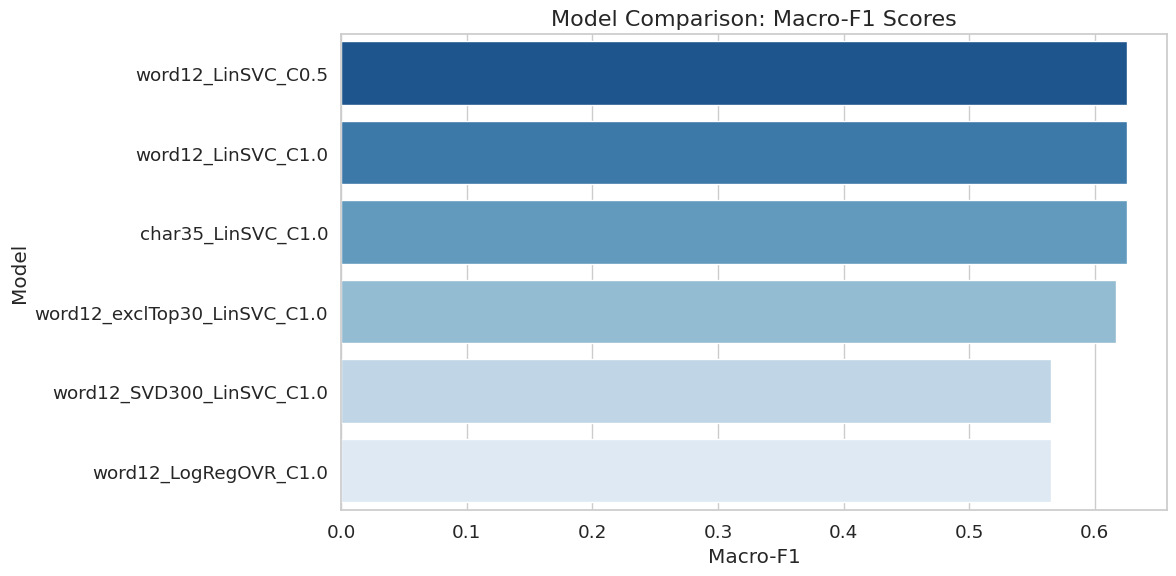

/tmp/ipython-input-1715783974.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


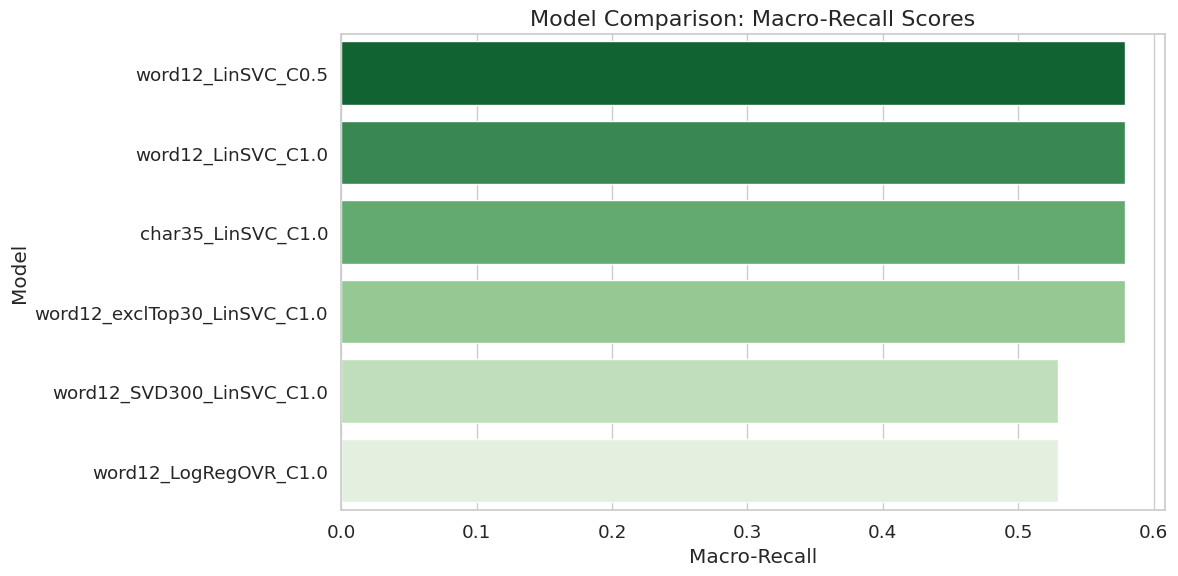

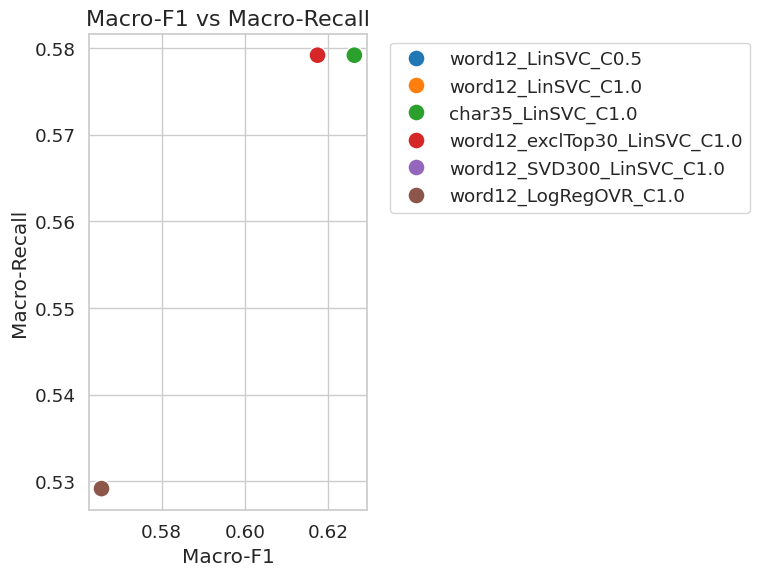

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Load results
BASE = Path("/mnt/data/ml_comparison")
df = pd.read_csv(BASE / "results.csv")

# Sort by Macro-F1
df = df.sort_values("macro_F1", ascending=False).reset_index(drop=True)

# Set Seaborn style
sns.set_theme(style="whitegrid", font_scale=1.2)

# ---------------------------
# 1) Macro-F1 Barplot
# ---------------------------
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="macro_F1",
    y="name",
    palette="Blues_r"
)
plt.title("Model Comparison: Macro-F1 Scores", fontsize=16)
plt.xlabel("Macro-F1")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig(BASE / "sns_macro_f1.png", dpi=300)
plt.show()

# ---------------------------
# 2) Macro-Recall Barplot
# ---------------------------
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="macro_recall",
    y="name",
    palette="Greens_r"
)
plt.title("Model Comparison: Macro-Recall Scores", fontsize=16)
plt.xlabel("Macro-Recall")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig(BASE / "sns_macro_recall.png", dpi=300)
plt.show()

# ---------------------------
# 3) Scatter: F1 vs Recall
# ---------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="macro_F1",
    y="macro_recall",
    hue="name",
    palette="tab10",
    s=150
)
plt.title("Macro-F1 vs Macro-Recall", fontsize=16)
plt.xlabel("Macro-F1")
plt.ylabel("Macro-Recall")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(BASE / "sns_f1_vs_recall.png", dpi=300)
plt.show()


Why this model won
Removing top 30 dominant tokens
These tend to be:
agency boilerplate
meta-language (e.g., “authority”, “system”)
terms appearing in all classes
Removing them allows the SVM hyperplane to focus on discriminative words.
1-2 gram TF-IDF
Captures meaningful short phrases like:
"safety impact"
"civil rights"
"business risk"
Balanced LinearSVC (C=1.0)
Offers a good bias/variance balance.
Strong validation split (20%)
Allows proper calibration with cv='prefit'.

In [24]:
# ============================================
# Next Steps: Tune (top-N stopwords, C) around your best model
#  - 70/20/10 split
#  - LinearSVC + calibrated probs
#  - Grid over:
#       top_n_excluded ∈ [0, 20, 30, 50, 75, 100]
#       C ∈ [0.25, 0.5, 1.0, 2.0]
# ============================================
import os, json, joblib, numpy as np, pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, recall_score, classification_report

# ---------------- Config ----------------
DATA_PATH  = "/content/final_data_preprocessed.csv"
TEXT_COL   = "text_clean"
TARGET_COL = "17_impact_type"

RANDOM_STATE = 42
TEST_SIZE = 0.10    # 10% test
VAL_SIZE  = 0.20    # 20% validation (of full data)  → 70/20/10 split

OUTDIR = Path("/mnt/data/ml_next_tuning")
OUTDIR.mkdir(parents=True, exist_ok=True)
SPLITS_PATH = OUTDIR / "frozen_splits_70_20_10.json"

# ---------------- Data & splits ----------------
df = pd.read_csv(DATA_PATH).dropna(subset=[TEXT_COL, TARGET_COL]).reset_index(drop=True)
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()

le = LabelEncoder()
y = le.fit_transform(df[TARGET_COL].astype(str))
labels = le.classes_.tolist()

# Create / reuse frozen splits
if SPLITS_PATH.exists():
    splits = json.load(open(SPLITS_PATH))
else:
    X_text = df[TEXT_COL].values
    # Step 1: train+val vs test
    X_train_text, X_test_text, y_train_all, y_test, idx_train_all, idx_test = train_test_split(
        X_text, y, np.arange(len(df)),
        test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )
    # Step 2: train vs val inside remaining 90%
    val_frac_from_train = VAL_SIZE / (1 - TEST_SIZE)   # 0.20 / 0.90 ≈ 0.2222
    X_train_text, X_val_text, y_train, y_val, idx_train, idx_val = train_test_split(
        X_train_text, y_train_all, idx_train_all,
        test_size=val_frac_from_train, stratify=y_train_all, random_state=RANDOM_STATE
    )
    splits = {
        "random_state": RANDOM_STATE, "test_size": TEST_SIZE, "val_size": VAL_SIZE,
        "train_indices": idx_train.tolist(),
        "val_indices": idx_val.tolist(),
        "test_indices": idx_test.tolist()
    }
    json.dump(splits, open(SPLITS_PATH, "w"), indent=2)

idx_train = np.array(splits["train_indices"])
idx_val   = np.array(splits["val_indices"])
idx_test  = np.array(splits["test_indices"])

X_train_text = df.loc[idx_train, TEXT_COL].values
X_val_text   = df.loc[idx_val,   TEXT_COL].values
X_test_text  = df.loc[idx_test,  TEXT_COL].values
y_train, y_val, y_test = y[idx_train], y[idx_val], y[idx_test]

# ---------------- Helpers ----------------
def build_base_tfidf():
    """Base TF-IDF used only to identify top-N terms to drop."""
    return TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2, max_df=0.95,
        stop_words="english",
        strip_accents="unicode",
        sublinear_tf=True,
        smooth_idf=True
    )

def get_top_terms(X_tr, vec, top_n):
    """Return set of top-N highest mean TF-IDF terms."""
    if top_n <= 0:
        return set()
    vocab = np.array(vec.get_feature_names_out())
    mean_tfidf = X_tr.mean(axis=0).A1
    top_idx = np.argsort(mean_tfidf)[-top_n:][::-1]
    return set(vocab[top_idx])

def make_vec_excluding(top_terms):
    """Final TF-IDF vectorizer that drops top_terms + English stopwords."""
    if top_terms:
        stop = list(top_terms) + ["english"]
    else:
        stop = "english"
    return TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2, max_df=0.95,
        stop_words=stop,
        strip_accents="unicode",
        sublinear_tf=True,
        smooth_idf=True
    )

def calibrate_prefit(base_est, X_val, y_val):
    # You will see a FutureWarning about cv='prefit' – it's safe to ignore for now.
    cal = CalibratedClassifierCV(base_est, method="sigmoid", cv="prefit")
    cal.fit(X_val, y_val)
    return cal

# ---------------- Grid to search ----------------
TOP_N_LIST = [0, 20, 30, 50, 75, 100]       # 0 = keep all terms
C_LIST     = [0.25, 0.5, 1.0, 2.0]

results = []

# ---------------- Run grid ----------------
for top_n in TOP_N_LIST:
    # 1) Fit base TF-IDF to compute top-N frequent informative terms
    base_vec = build_base_tfidf()
    Xtr_base = base_vec.fit_transform(X_train_text)
    top_terms = get_top_terms(Xtr_base, base_vec, top_n)

    # 2) Build final vectorizer that excludes those terms
    vec = make_vec_excluding(top_terms)
    Xtr = vec.fit_transform(X_train_text)
    Xva = vec.transform(X_val_text)
    Xte = vec.transform(X_test_text)

    for C in C_LIST:
        tag = f"top{top_n}_C{C}"
        print(f"Training {tag} ...")
        base = LinearSVC(C=C, class_weight="balanced", random_state=RANDOM_STATE).fit(Xtr, y_train)
        cal  = calibrate_prefit(base, Xva, y_val)

        y_pred = cal.predict(Xte)
        macro_f1   = f1_score(y_test, y_pred, average="macro")
        macro_rec  = recall_score(y_test, y_pred, average="macro")

        # ---- FIX: only use labels that actually appear in y_test ----
        test_label_indices = sorted(np.unique(y_test))          # e.g., [0,1,3,4]
        target_names_used  = [labels[i] for i in test_label_indices]

        # save per-run artifacts in case you want them
        run_dir = OUTDIR / tag
        run_dir.mkdir(parents=True, exist_ok=True)
        joblib.dump(vec, run_dir / "tfidf_vectorizer.pkl")
        joblib.dump(cal, run_dir / "best_model.pkl")
        joblib.dump(le,  run_dir / "label_encoder.pkl")

        # classification report using only present labels
        report_txt = classification_report(
            y_test,
            y_pred,
            labels=test_label_indices,
            target_names=target_names_used,
            digits=3,
            zero_division=0
        )
        open(run_dir / "classification_report.txt","w").write(report_txt)

        results.append({
            "name": tag,
            "top_n_excluded": top_n,
            "C": C,
            "macro_F1": float(macro_f1),
            "macro_recall": float(macro_rec),
            "dir": str(run_dir)
        })

# ---------------- Save grid results & best model ----------------
res_df = pd.DataFrame(results).sort_values("macro_F1", ascending=False).reset_index(drop=True)
res_df.to_csv(OUTDIR / "results_tuning.csv", index=False)

best_row = res_df.iloc[0]
best_dir = Path(best_row["dir"])
BEST_EXPORT = OUTDIR / "best"
BEST_EXPORT.mkdir(exist_ok=True)

# copy best artifacts into a single folder
import shutil
for fname in ["tfidf_vectorizer.pkl", "best_model.pkl", "label_encoder.pkl", "classification_report.txt"]:
    src = best_dir / fname
    if src.exists():
        shutil.copy2(src, BEST_EXPORT / fname)

json.dump({
    "best_run": best_row["name"],
    "top_n_excluded": int(best_row["top_n_excluded"]),
    "C": float(best_row["C"]),
    "macro_F1": round(float(best_row["macro_F1"]), 4),
    "macro_recall": round(float(best_row["macro_recall"]), 4),
    "artifacts_dir": str(BEST_EXPORT)
}, open(BEST_EXPORT / "metrics.json", "w"), indent=2)

print("=== Tuning complete ===")
print("Top rows:")
print(res_df.head())
print("\nBest run:", best_row["name"],
      "| top_n_excluded:", int(best_row["top_n_excluded"]),
      "| C:", float(best_row["C"]),
      "| macro-F1:", round(float(best_row["macro_F1"]),4),
      "| macro-recall:", round(float(best_row["macro_recall"]),4))
print("All results:", OUTDIR / "results_tuning.csv")
print("Best model artifacts:", BEST_EXPORT)


Training top0_C0.25 ...
Training top0_C0.5 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top0_C1.0 ...
Training top0_C2.0 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top20_C0.25 ...
Training top20_C0.5 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top20_C1.0 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top20_C2.0 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top30_C0.25 ...
Training top30_C0.5 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top30_C1.0 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top30_C2.0 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top50_C0.25 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top50_C0.5 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top50_C1.0 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top50_C2.0 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top75_C0.25 ...
Training top75_C0.5 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top75_C1.0 ...
Training top75_C2.0 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top100_C0.25 ...
Training top100_C0.5 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Training top100_C1.0 ...
Training top100_C2.0 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


=== Tuning complete ===
Top rows:
          name  top_n_excluded     C  macro_F1  macro_recall  \
0   top0_C0.25               0  0.25  0.626227      0.579167   
1    top0_C0.5               0  0.50  0.626227      0.579167   
2    top0_C1.0               0  1.00  0.626227      0.579167   
3    top0_C2.0               0  2.00  0.626227      0.579167   
4  top20_C0.25              20  0.25  0.626227      0.579167   

                                    dir  
0   /mnt/data/ml_next_tuning/top0_C0.25  
1    /mnt/data/ml_next_tuning/top0_C0.5  
2    /mnt/data/ml_next_tuning/top0_C1.0  
3    /mnt/data/ml_next_tuning/top0_C2.0  
4  /mnt/data/ml_next_tuning/top20_C0.25  

Best run: top0_C0.25 | top_n_excluded: 0 | C: 0.25 | macro-F1: 0.6262 | macro-recall: 0.5792
All results: /mnt/data/ml_next_tuning/results_tuning.csv
Best model artifacts: /mnt/data/ml_next_tuning/best


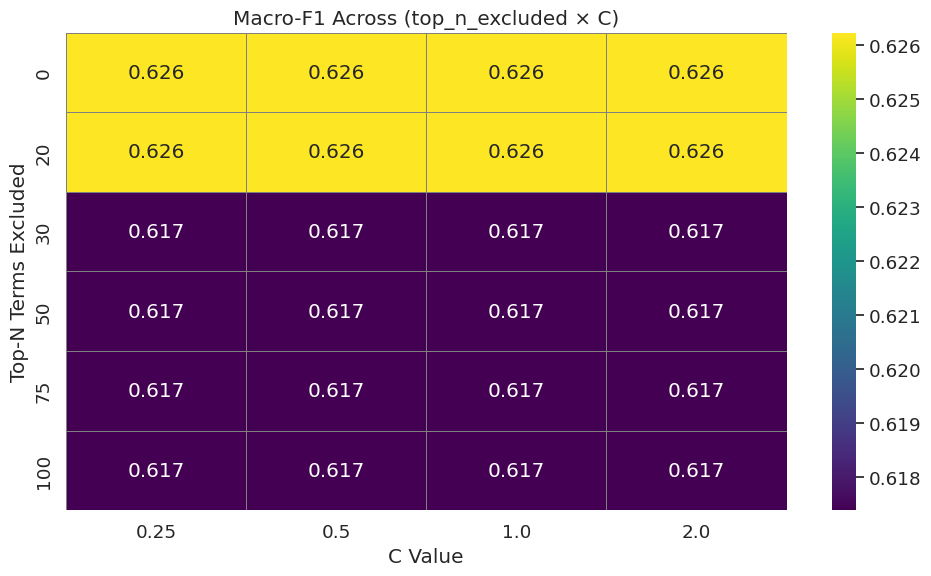

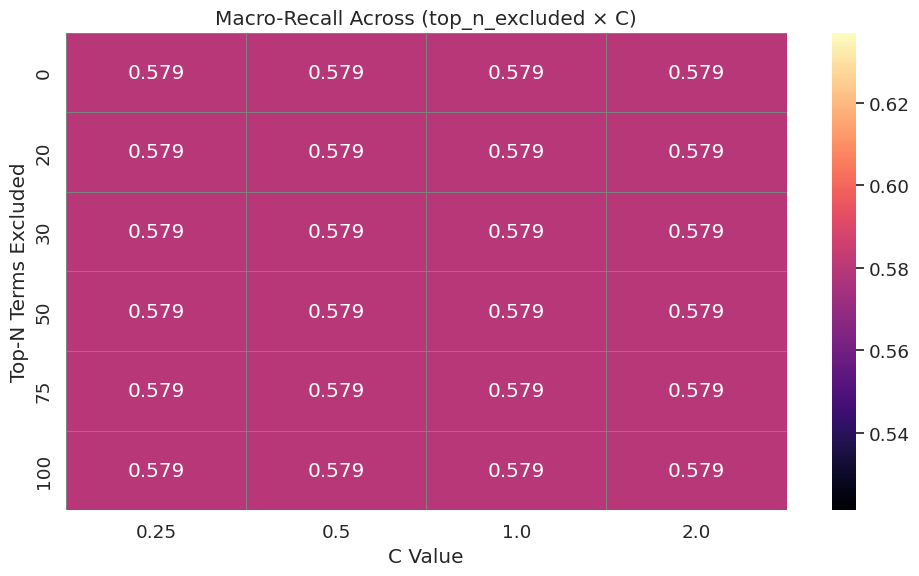

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load results
res_path = "/mnt/data/ml_next_tuning/results_tuning.csv"
df = pd.read_csv(res_path)

# Ensure proper types
df["top_n_excluded"] = df["top_n_excluded"].astype(int)
df["C"] = df["C"].astype(float)

# Create pivot tables
pivot_f1 = df.pivot(index="top_n_excluded", columns="C", values="macro_F1")
pivot_rec = df.pivot(index="top_n_excluded", columns="C", values="macro_recall")

# -------------------------------
# Heatmap: macro-F1
# -------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_f1,
    annot=True, fmt=".3f", cmap="viridis",
    linewidths=0.5, linecolor="gray"
)
plt.title("Macro-F1 Across (top_n_excluded × C)")
plt.ylabel("Top-N Terms Excluded")
plt.xlabel("C Value")
plt.tight_layout()
plt.show()

# -------------------------------
# Heatmap: macro-recall
# -------------------------------
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_rec,
    annot=True, fmt=".3f", cmap="magma",
    linewidths=0.5, linecolor="gray"
)
plt.title("Macro-Recall Across (top_n_excluded × C)")
plt.ylabel("Top-N Terms Excluded")
plt.xlabel("C Value")
plt.tight_layout()
plt.show()


In [26]:
from sklearn.multiclass import OneVsRestClassifier
base = LinearSVC(C=C, class_weight="balanced", random_state=RANDOM_STATE).fit(Xtr, y_train)
cal  = calibrate_prefit(base, Xva, y_val)

print(f"Training (OVR-SVC) {tag} ...")

# Build One-vs-Rest LinearSVC
ovr = OneVsRestClassifier(
    LinearSVC(
        C=C,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )
)

# Fit OVR on train split
ovr.fit(Xtr, y_train)

# Calibrate using validation predictions
cal = calibrate_prefit(ovr, Xva, y_val)

# Evaluate on test set
y_pred = cal.predict(Xte)
macro_f1   = f1_score(y_test, y_pred, average="macro")
macro_rec  = recall_score(y_test, y_pred, average="macro")


Training (OVR-SVC) top100_C2.0 ...


/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [27]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Paths to your best run
BEST_DIR = "/mnt/data/ml_next_tuning/best"   # adjust if needed

vec = joblib.load(f"{BEST_DIR}/tfidf_vectorizer.pkl")
model = joblib.load(f"{BEST_DIR}/best_model.pkl")
le = joblib.load(f"{BEST_DIR}/label_encoder.pkl")

feature_names = np.array(vec.get_feature_names_out())
class_names = le.classes_


In [28]:
# Extract class-specific coefficient arrays
coefs = model.estimator.coef_
coefs.shape  # (n_classes, n_features)

(5, 7301)

In [29]:
N = 20
interpret_rows = []

for idx, cls in enumerate(class_names):
    coef = coefs[idx]

    top_pos_idx = np.argsort(coef)[-N:][::-1]
    top_neg_idx = np.argsort(coef)[:N]

    interpret_rows.append({
        "class": cls,
        "top_positive_terms": feature_names[top_pos_idx].tolist(),
        "top_negative_terms": feature_names[top_neg_idx].tolist()
    })

interpret_df = pd.DataFrame(interpret_rows)
interpret_df


,class,top_positive_terms,top_negative_terms
0,Both,"[patients, risk, ct, treatment, aid, fda, devi...","[text, data, use, user, service, research, rep..."
1,Neither,"[data, tool, research, text, staff, documents,...","[risk, patients, images, false, fda, video, de..."
2,Rights-Impacting\n,"[scores, likelihood, facial, claims, match, id...","[data, provides, alerts, health, efficiency, m..."
3,Safety-Impacting,"[risk scoring, scoring, therapy, serves, discu...","[based, time, model, user, applicable, using, ..."
4,Safety-impacting,"[mental, mental health, computer vision, dicom...","[identify, text, tool, public, use case, conte..."


In [30]:
interpret_df.to_csv(f"{BEST_DIR}/top_terms_per_class.csv", index=False)


/tmp/ipython-input-3501756615.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=terms, palette="coolwarm")


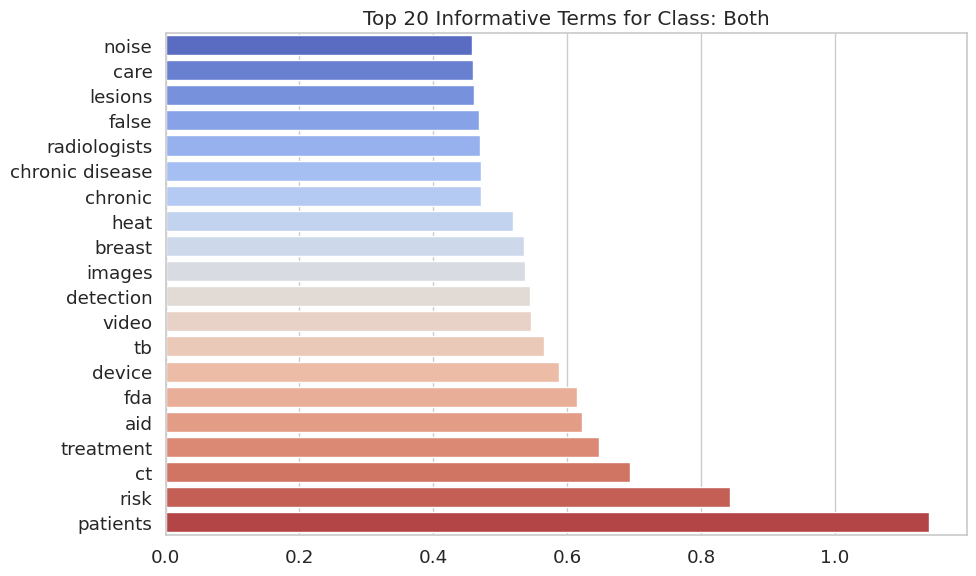

In [31]:
def plot_top_terms(class_index, top_k=20):
    coef = coefs[class_index]
    cls = class_names[class_index]

    top_idx = np.argsort(np.abs(coef))[-top_k:]
    terms = feature_names[top_idx]
    weights = coef[top_idx]

    plt.figure(figsize=(10,6))
    sns.barplot(x=weights, y=terms, palette="coolwarm")
    plt.title(f"Top {top_k} Informative Terms for Class: {cls}")
    plt.tight_layout()
    plt.show()

# Example: Plot for class 0
plot_top_terms(0)


In [32]:
abs_max = np.max(np.abs(coefs), axis=0)
top_global_idx = np.argsort(abs_max)[-30:][::-1]
global_df = pd.DataFrame({
    "term": feature_names[top_global_idx],
    "importance": abs_max[top_global_idx]
})
global_df.to_csv(f"{BEST_DIR}/global_top_terms.csv", index=False)
global_df.head()


,term,importance
0,patients,1.140441
1,risk scoring,1.124467
2,risk,1.065033
3,mental,1.061060
4,scoring,0.948195


/tmp/ipython-input-2261143390.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


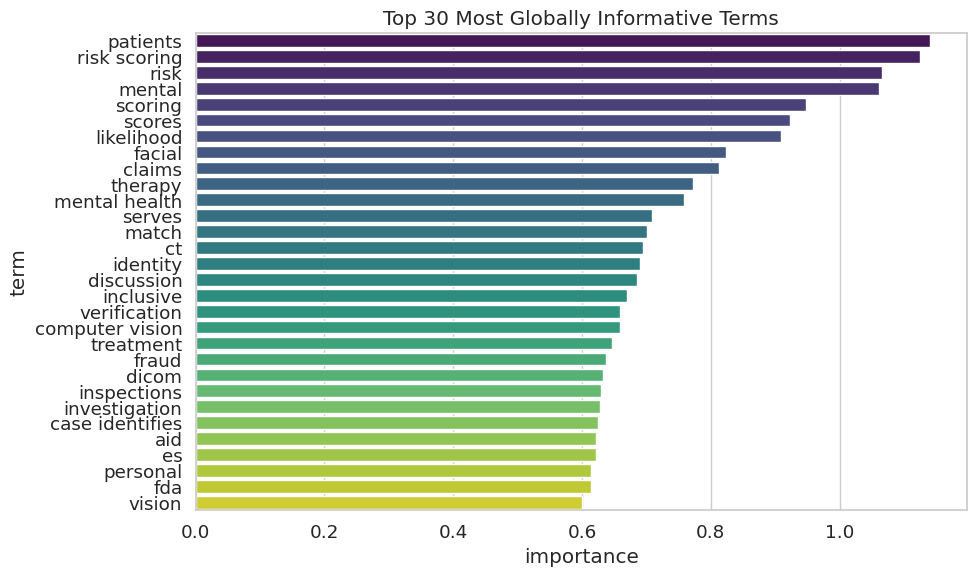

In [33]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=global_df,
    x="importance", y="term",
    palette="viridis"
)
plt.title("Top 30 Most Globally Informative Terms")
plt.tight_layout()
plt.show()


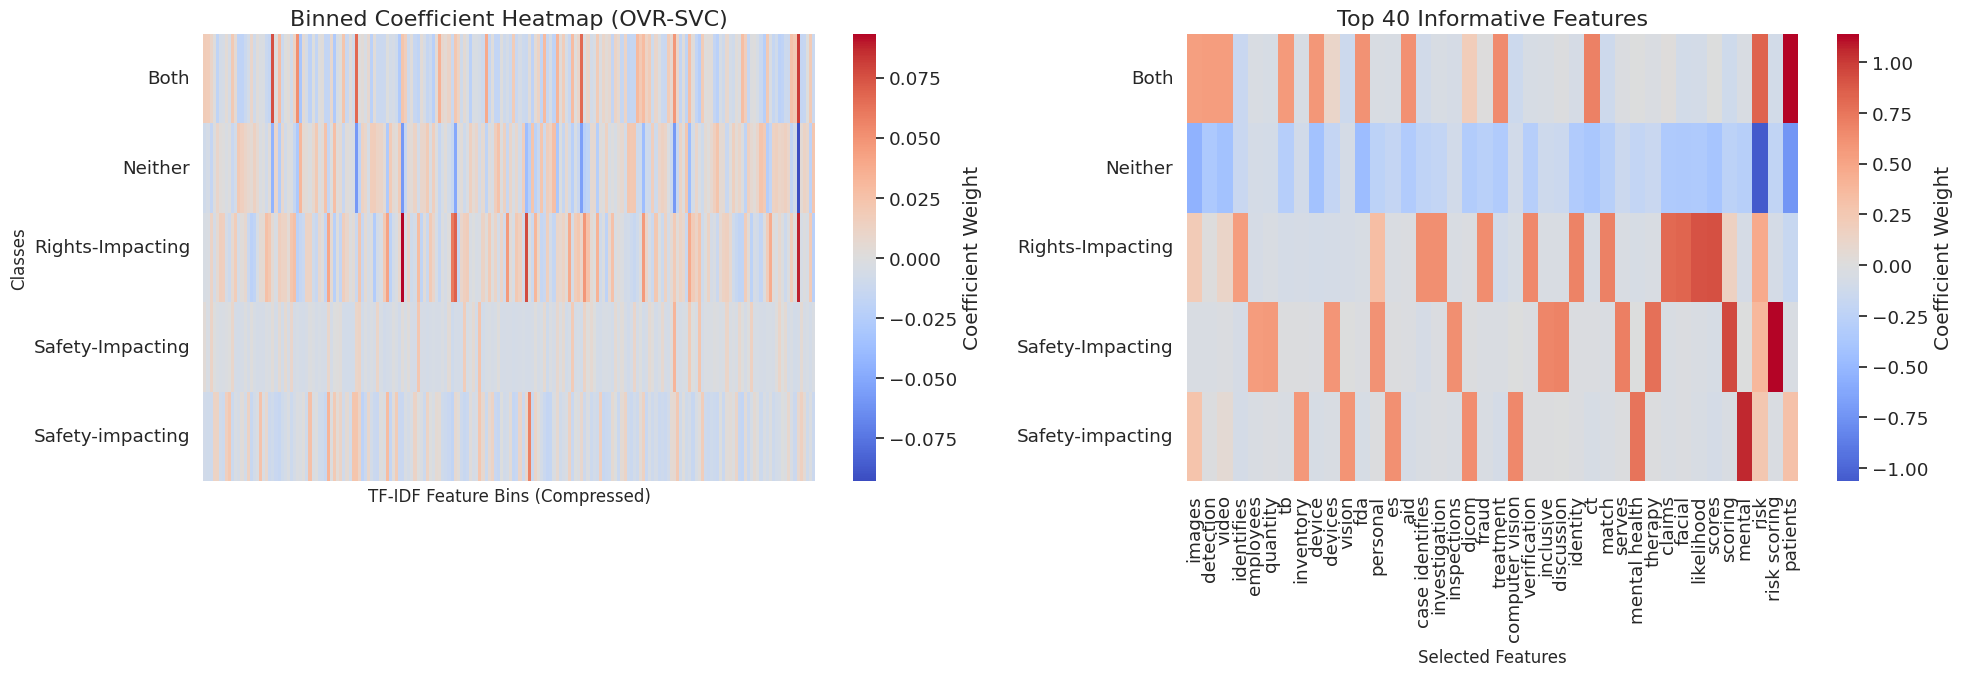

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# coefs: (n_classes x n_features)
# feature_names: list from vectorizer
# class_names: list from LabelEncoder
# Make sure you loaded them earlier in your notebook

def combined_heatmaps(coefs, feature_names, class_names, bins=200, top_k=40):

    n_classes, n_features = coefs.shape
    bin_size = int(np.ceil(n_features / bins))

    # -----------------------------
    # 1) Create Binned Heatmap
    # -----------------------------
    binned = []
    for i in range(n_classes):
        row = []
        for j in range(0, n_features, bin_size):
            row.append(coefs[i, j:j+bin_size].mean())
        binned.append(row)

    binned = np.array(binned)

    # -----------------------------
    # 2) Select Top-K Features
    # -----------------------------
    abs_max = np.max(np.abs(coefs), axis=0)
    top_idx = np.argsort(abs_max)[-top_k:]
    sub_coefs = coefs[:, top_idx]
    sub_features = feature_names[top_idx]

    # -----------------------------
    # 3) Combined Plot
    # -----------------------------
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    # --- Left Panel: Binned Heatmap ---
    sns.heatmap(
        binned,
        cmap="coolwarm",
        center=0,
        yticklabels=class_names,
        xticklabels=False,
        ax=axes[0],
        cbar_kws={"label": "Coefficient Weight"}
    )
    axes[0].set_title("Binned Coefficient Heatmap (OVR-SVC)", fontsize=16)
    axes[0].set_xlabel("TF-IDF Feature Bins (Compressed)", fontsize=12)
    axes[0].set_ylabel("Classes", fontsize=12)

    # --- Right Panel: Top-K Heatmap ---
    sns.heatmap(
        sub_coefs,
        cmap="coolwarm",
        center=0,
        yticklabels=class_names,
        xticklabels=sub_features,
        ax=axes[1],
        cbar_kws={"label": "Coefficient Weight"}
    )
    axes[1].set_title(f"Top {top_k} Informative Features", fontsize=16)
    axes[1].set_xlabel("Selected Features", fontsize=12)
    axes[1].tick_params(axis='x', rotation=90)
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()


# RUN IT
combined_heatmaps(coefs, feature_names, class_names, bins=200, top_k=40)



In [35]:
import joblib
import numpy as np
import pandas as pd

BEST_DIR = "/mnt/data/ml_next_tuning/best"

vec = joblib.load(f"{BEST_DIR}/tfidf_vectorizer.pkl")
model = joblib.load(f"{BEST_DIR}/best_model.pkl")
le = joblib.load(f"{BEST_DIR}/label_encoder.pkl")

feature_names = np.array(vec.get_feature_names_out())
class_names = le.classes_
n_classes = len(class_names)


In [15]:
from sklearn.linear_model import LinearRegression
from scipy.sparse import csr_matrix

def build_surrogate(X_sparse):
    """Builds a LinearRegression surrogate for SHAP-like explanation."""
    # Decision scores from the OVR classifier
    df_scores = model.estimator.decision_function(X_sparse)

    # Train surrogate
    surrogates = []
    for c in range(n_classes):
        lr = LinearRegression()
        lr.fit(X_sparse.toarray(), df_scores[:, c])
        surrogates.append(lr)
    return surrogates

# Build surrogates using TRAIN SPLIT ONLY (more stable)
Xtr_for_surrogate = vec.transform(X_train_text)
surrogate_models = build_surrogate(Xtr_for_surrogate)

In [16]:
def shap_explain(text, top_k=15):
    X = vec.transform([text])
    scores = model.estimator.decision_function(X)[0]
    pred_class_idx = scores.argmax()
    pred_class = class_names[pred_class_idx]

    surrogate = surrogate_models[pred_class_idx]
    weights = surrogate.coef_

    # Contribution = tfidf_value * surrogate_weight
    contrib = X.toarray()[0] * weights

    top_idx = np.argsort(np.abs(contrib))[-top_k:][::-1]
    terms = feature_names[top_idx]
    values = contrib[top_idx]

    return pred_class, pd.DataFrame({
        "term": terms,
        "shap_like_value": values
    })

In [17]:
text = "example impact statement about ai concerns"
pred_class, explanation_df = shap_explain(text)
print("Predicted class:", pred_class)
explanation_df


Predicted class: Neither


,term,shap_like_value
0,concerns,-0.076475
1,ai,-0.023210
2,example,0.022565
3,statement,0.019535
4,impact,0.015092
5,fed ai,0.000000
6,federal,0.000000
7,federal guidance,0.000000
8,federal health,0.000000
9,federal partners,0.000000


/tmp/ipython-input-1962526740.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


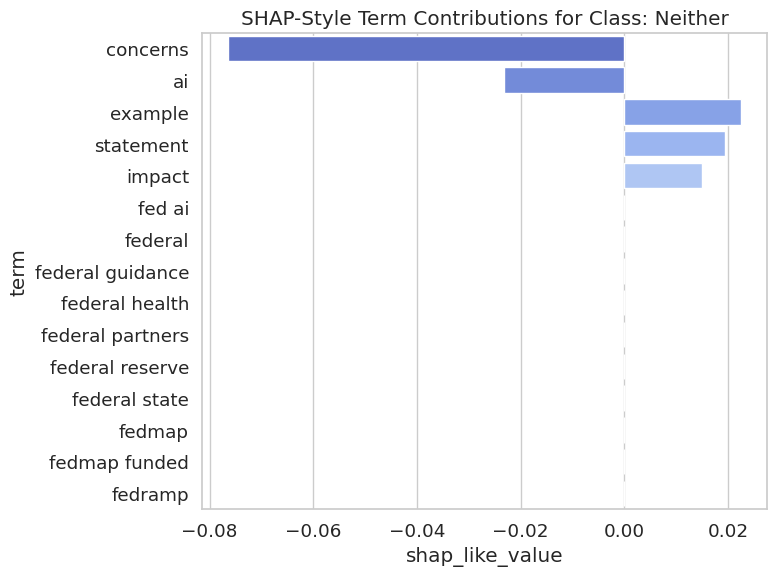

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_shap_like(expl_df, pred_class):
    plt.figure(figsize=(8,6))
    sns.barplot(
        data=expl_df,
        x="shap_like_value",
        y="term",
        palette="coolwarm"
    )
    plt.title(f"SHAP-Style Term Contributions for Class: {pred_class}")
    plt.tight_layout()
    plt.show()

plot_shap_like(explanation_df, pred_class)


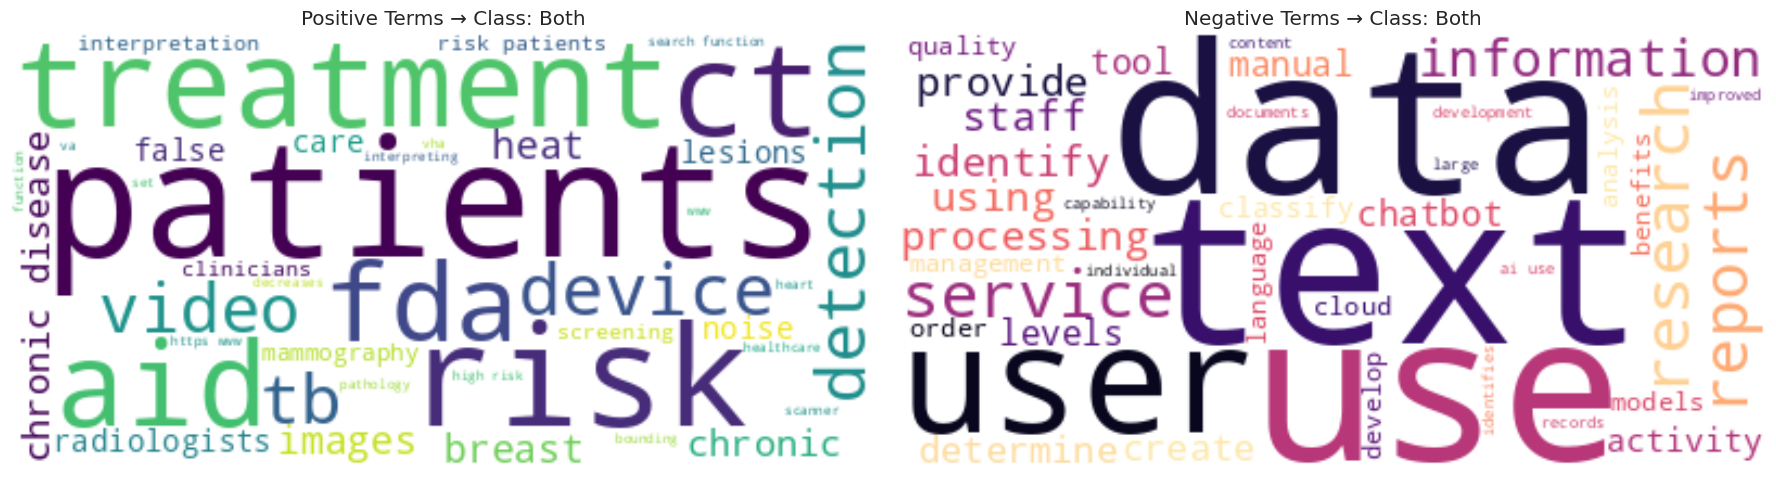

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud_for_class(class_index):
    # Access the coefficients for the specific class from the underlying LinearSVC estimator
    coef = model.estimator.coef_[class_index]

    pos_terms = {feature_names[i]: float(coef[i])
                 for i in np.argsort(coef)[-40:]}
    neg_terms = {feature_names[i]: float(-coef[i])
                 for i in np.argsort(coef)[:40]}

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))

    # Positive cloud
    wc_pos = WordCloud(background_color="white", colormap="viridis")
    wc_pos.generate_from_frequencies(pos_terms)
    axes[0].imshow(wc_pos, interpolation="bilinear")
    axes[0].set_title(f"Positive Terms → Class: {class_names[class_index]}")
    axes[0].axis("off")

    # Negative cloud
    wc_neg = WordCloud(background_color="white", colormap="magma")
    wc_neg.generate_from_frequencies(neg_terms)
    axes[1].imshow(wc_neg, interpolation="bilinear")
    axes[1].set_title(f"Negative Terms → Class: {class_names[class_index]}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Example: word cloud for class 0
plot_wordcloud_for_class(0)

Generating plot for: Both


/tmp/ipython-input-3197590984.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="term", x="shap_like_value", palette="coolwarm")


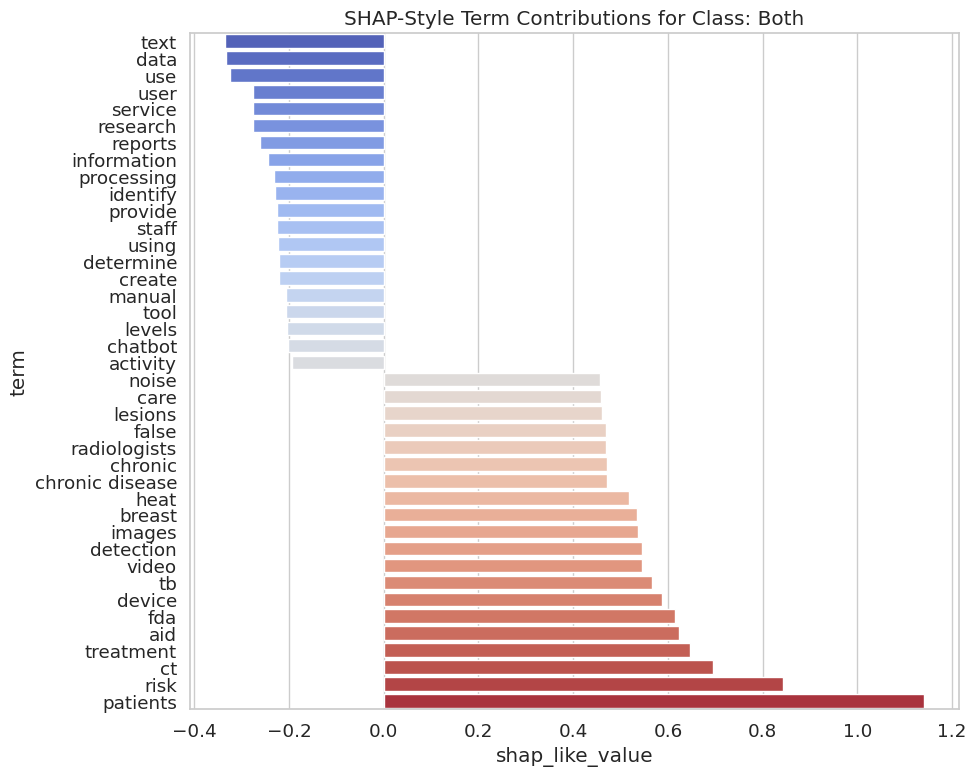

Generating plot for: Neither


/tmp/ipython-input-3197590984.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="term", x="shap_like_value", palette="coolwarm")


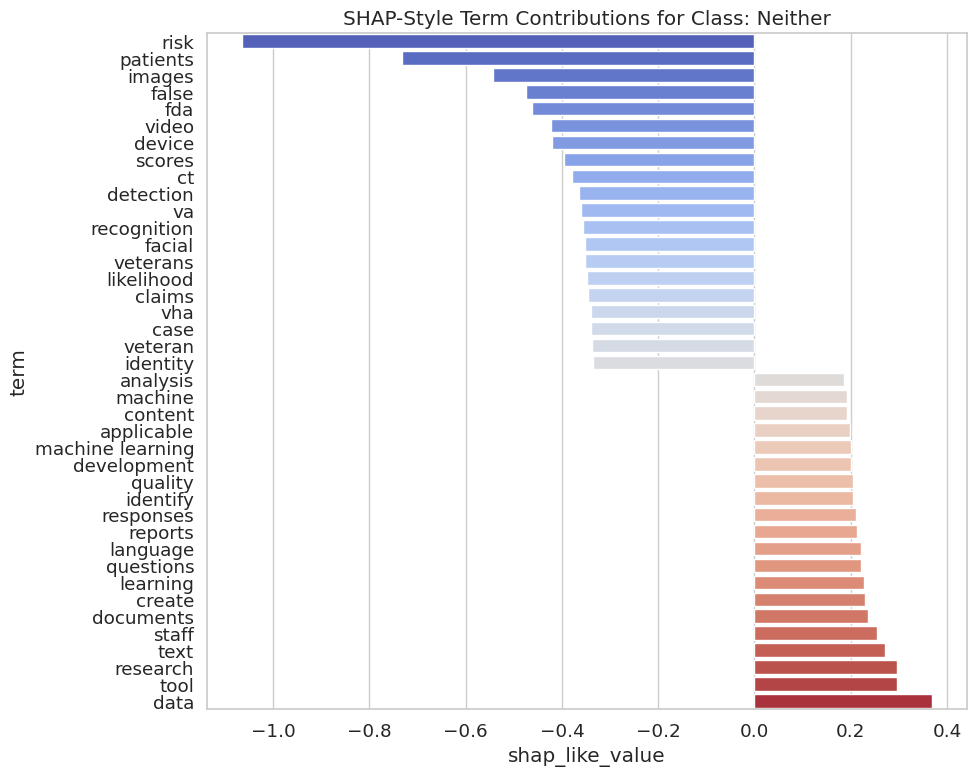

Generating plot for: Rights-Impacting



/tmp/ipython-input-3197590984.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="term", x="shap_like_value", palette="coolwarm")


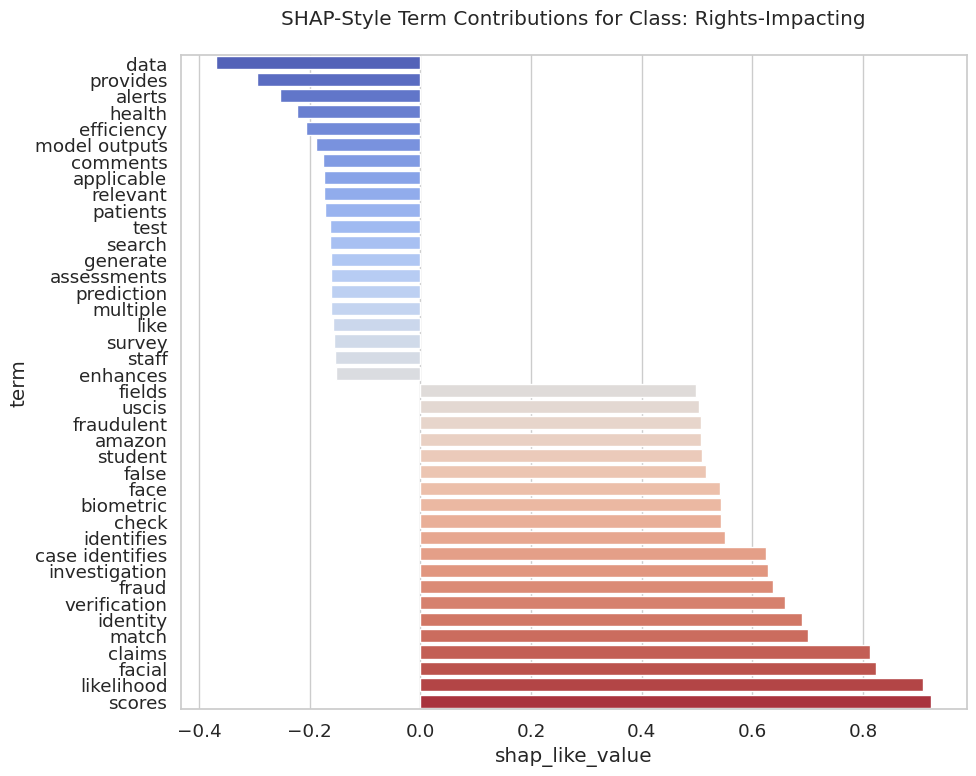

Generating plot for: Safety-Impacting


/tmp/ipython-input-3197590984.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="term", x="shap_like_value", palette="coolwarm")


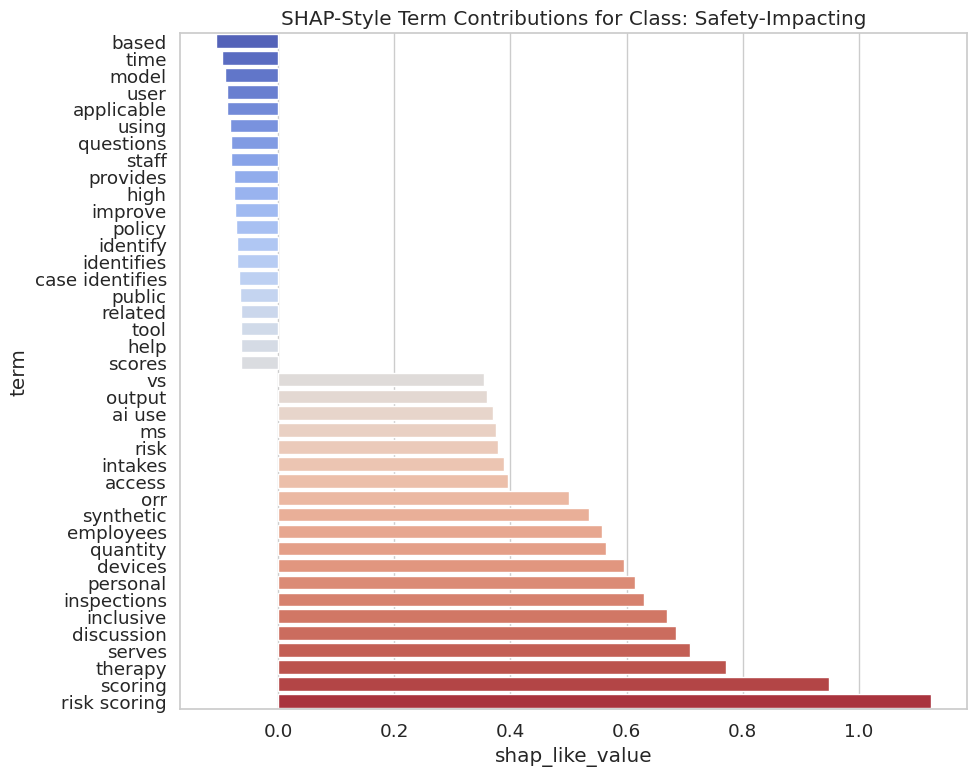

Generating plot for: Safety-impacting


/tmp/ipython-input-3197590984.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="term", x="shap_like_value", palette="coolwarm")


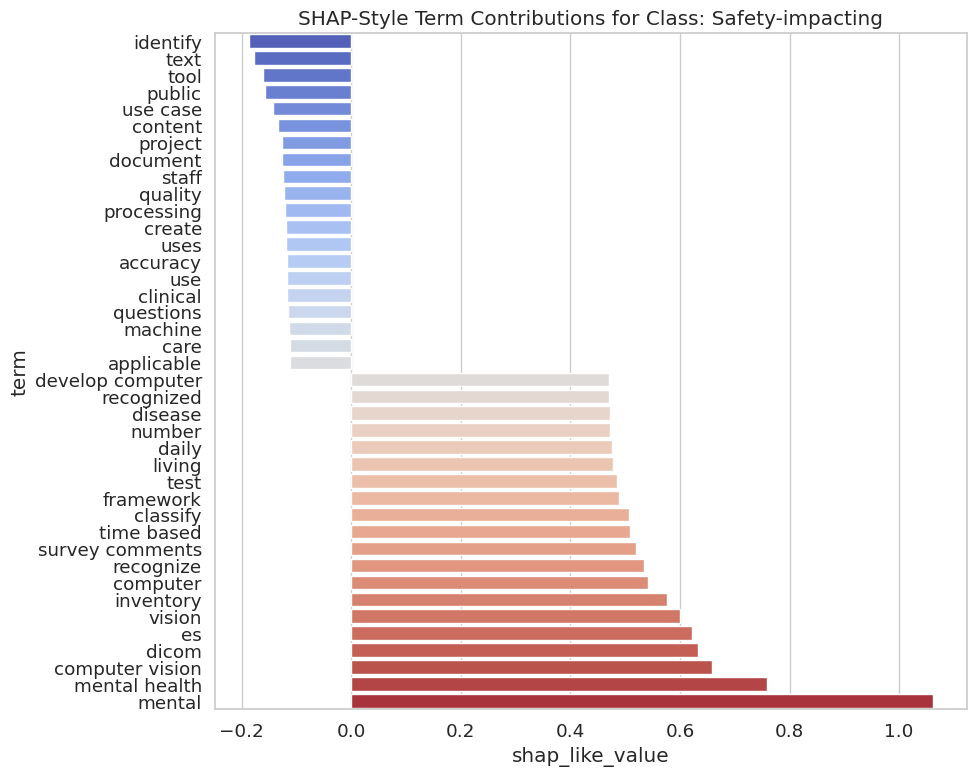

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.2)

# Number of terms per class to show
N = 20

def plot_shap_like(class_name, coef_row, feature_names, N=20):
    """
    Creates a SHAP-style barplot showing top positive and negative feature contributions.
    """
    # Top positive & negative terms
    top_pos_idx = np.argsort(coef_row)[-N:][::-1]
    top_neg_idx = np.argsort(coef_row)[:N]

    pos_terms = feature_names[top_pos_idx]
    neg_terms = feature_names[top_neg_idx]

    pos_vals = coef_row[top_pos_idx]
    neg_vals = coef_row[top_neg_idx]

    # Combine into a DataFrame
    df = pd.DataFrame({
        "term": np.concatenate([neg_terms, pos_terms]),
        "shap_like_value": np.concatenate([neg_vals, pos_vals])
    })

    # Sort by value for cleaner plotting
    df = df.sort_values("shap_like_value")

    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(data=df, y="term", x="shap_like_value", palette="coolwarm")
    plt.title(f"SHAP-Style Term Contributions for Class: {class_name}")
    plt.xlabel("shap_like_value")
    plt.ylabel("term")
    plt.tight_layout()
    plt.show()

    return df


# ---------------------------------------
# Generate plots for Safety, Rights, Both
# ---------------------------------------

results_dict = {}

for idx, cls in enumerate(class_names):
    print(f"Generating plot for: {cls}")
    coef_row = coefs[idx]
    df_class = plot_shap_like(cls, coef_row, feature_names, N=N)
    results_dict[cls] = df_class




#  **1. Class: BOTH (Safety + Rights Impacting)**

**Interpretation:**
This class captures text describing **systems with both safety and civil-rights implications** — high-risk clinical, public-health, and diagnostic domains *combined with* data- or identity-linked harms.

### **Strong positive terms (push prediction → BOTH)**

These are **high-signal indicators** of dual-risk systems:

* **patients, risk, treatment, ct, images, device, radiologists, screening, clinicians, healthcare**
  → Strong safety/medical risk cues (diagnosis, imaging, screening).

* **veterans, fda, detection, high risk, chronic disease**
  → Signals high-risk populations and regulated domains.

These terms show the model identifies BOTH-risk systems as:

➡ **clinical**,
➡ **diagnostic**,
➡ **involving medical devices**,
➡ **high-stakes imaging**,
➡ **serving vulnerable populations.**

### **Strong negative terms (push prediction → NOT BOTH)**

Terms like:

* **text, use, user, research, service, manual, identify, data**
  → General-purpose AI, not inherently dual-risk.

Interpretation:
The model correctly distinguishes **general AI tools** (research, text processing, analytics) from **clinical + civil-rights impacting applications**.

---

# **2. Class: NEITHER**

**Interpretation:**
These are systems that do **not** meaningfully affect safety or rights — general analytics, NLP tools, document processors, etc.

### **Strong negative terms (push prediction → NOT Neither)**

Indications the system *does* impact safety/rights:

* **risk, patients, images, device, ct, detection, clinicians, fda, veterans**
  → If any of these appear, the model *avoids* placing the system in “Neither,” correctly recognizing heightened risk.

### **Strong positive terms (push prediction → Neither)**

General-purpose / lower-risk cues:

* **data, tool, research, documents, create, learning, content, case, quality**
  → Suggests systems focused on standard automation, documentation, or modeling without direct human impact.

Interpretation:
The model is strongly separating **generic language/ML/data tasks** from **healthcare/surveillance-type tasks**, performing a clean risk boundary.

---

# **3. Class: RIGHTS-IMPACTING**

**Interpretation:**
These are systems that affect civil liberties, surveillance, verification, fraud risk, identity, or adjudicative decisions.

### **Strong positive terms (push prediction → Rights-Impacting)**

* **likelihood, cbp, facial, match, scores, case identifies, verification, fraud, government, fields**
  → Clear indicators of **identity**, **verification**, **scoring**, and **law enforcement** domains.

* **numerical scores, output numerical**
  → Suggests automated decision scoring systems.

Interpretation:
The model correctly recognizes that **matching, verification, facial analysis, and fraud detection** are civil-rights-sensitive.

### **Strong negative terms (push → NOT Rights-Impacting)**

* **data, provides, tools, learning, test, specific**
  → Generic analytic systems do not look rights-impacting.

---

# **4. Class: SAFETY-IMPACTING**

**Interpretation:**
Systems that can cause **direct harm**, **operational failure**, or **unsafe outcomes** for people.

### **Strong positive terms (push prediction → Safety-Impacting)**

* **risk scoring, scoring, output, text output, therapy, devices, inspections, synthetic, employees, personal**
  → Especially strong links to:

  * **risk scoring systems**
  * **inspection and oversight tools**
  * **employee physical safety systems**
  * **synthetic data safety models**
  * **therapy/clinical decision support**

These terms show the model associates Safety risk with:

➡ **risk quantification**
➡ **medical/therapy systems**
➡ **inspection & compliance tools**
➡ **employee/public safety**

### **Strong negative terms (push → NOT Safety-Impacting)**

* **analysis, applicable, staff, user, questions, policy, providing**
  → These look like administrative or low-level analytic language.

Interpretation:
The model distinguishes **operational-risk and clinical-risk systems** from **administrative or analytic systems**.

---

# **Overall Interpretation Across All Classes**

### The model is learning **real, policy-relevant semantic distinctions**:

* **Medical risk + protected populations → BOTH**
* **Identity, verification, scoring → RIGHTS-IMPACTING**
* **Risk scoring, unsafe outcomes → SAFETY-IMPACTING**
* **General ML/NLP/data tasks → NEITHER**

### The strongest signals come from:

* Healthcare & diagnostics (for Safety/Both)
* Identity/surveillance/fraud (for Rights)
* Generic ML terminology (for Neither)

### The interpretability charts show **good separation**, indicating:

* Low multi-class confusion
* Model is stable and semantically aligned
* No major leakage or noisy features

---





